In [1]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
from matplotlib import gridspec

In [5]:
spike_data_binned = np.load('/home/linggel/neuroscience/standard_data_format/spike_data_binned.npy')
lfp_data_sampled = np.load('/home/linggel/neuroscience/standard_data_format/lfp_data_sampled.npy')
lfp_data_sampled = np.swapaxes(lfp_data_sampled, 1, 2)
trial_info = np.load('/home/linggel/neuroscience/standard_data_format/trial_info.npy')

In [6]:
rat_correct = trial_info[:, 0] == 1
in_sequence = trial_info[:, 1] == 1
not_odor_e = trial_info[:, 3] < 5
select = rat_correct & in_sequence & not_odor_e

In [7]:
spike_data_binned = spike_data_binned[select, :, :]
spike_data_binned = (spike_data_binned - np.mean(spike_data_binned)) / np.std(spike_data_binned)
lfp_data_sampled = lfp_data_sampled[select, :, :]

In [8]:
decoding_start = 210
decoding_end = decoding_start + 25

In [9]:
decoding_data_spike = spike_data_binned[:, :, decoding_start:decoding_end]
decoding_data_lfp = lfp_data_sampled[:, :, decoding_start:decoding_end]

In [10]:
from keras.utils import np_utils

Using Theano backend.


In [11]:
decoding_target = np_utils.to_categorical((trial_info[select, 3] - 1).astype(int))

In [12]:
tetrode_ids = [1, 10, 12, 13, 14, 15, 16, 18, 19, 2, 20, 21, 22, 23, 3, 4, 5, 6, 7, 8, 9]

In [13]:
tetrode_units = {1:3, 10:0, 12:1, 13:8, 14:4, 15:6, 16:1, 18:0, 19:4, 2:3,
                20:0, 21:1, 22:5, 23:7, 3:0, 4:0, 5:0, 6:0, 7:1, 8:1, 9:1}

In [14]:
def organize_tetrode(spike_data, lfp_data, tetrode_ids, tetrode_units, verbose=True):
    """
    Organize spike and LFP data by tetrode.
    """
    all_tetrode_data = []
    i = 0
    for j, t in enumerate(tetrode_ids):
        k = tetrode_units[t]
        if k == 0:
            continue
        tetrode_lfp = np.expand_dims(lfp_data[:, j, :], axis=1)
        tetrode_spike = spike_data[:, i:(i + k), :]
        if len(tetrode_spike.shape) == 2:
            tetrode_spike = np.expand_dims(tetrode_spike, axis=1)
        tetrode_data = np.concatenate([tetrode_lfp, tetrode_spike], axis=1)
        tetrode_data = np.expand_dims(tetrode_data, axis=1)
        all_tetrode_data.append(tetrode_data)
        if verbose:
            print('Current tetrode {t} with {k} neurons/units'.format(t=t, k=k))
            print(tetrode_data.shape)
        i += k
    return all_tetrode_data

In [15]:
tetrode_data = organize_tetrode(decoding_data_spike, decoding_data_lfp, tetrode_ids, tetrode_units)

Current tetrode 1 with 3 neurons/units
(168, 1, 4, 25)
Current tetrode 12 with 1 neurons/units
(168, 1, 2, 25)
Current tetrode 13 with 8 neurons/units
(168, 1, 9, 25)
Current tetrode 14 with 4 neurons/units
(168, 1, 5, 25)
Current tetrode 15 with 6 neurons/units
(168, 1, 7, 25)
Current tetrode 16 with 1 neurons/units
(168, 1, 2, 25)
Current tetrode 19 with 4 neurons/units
(168, 1, 5, 25)
Current tetrode 2 with 3 neurons/units
(168, 1, 4, 25)
Current tetrode 21 with 1 neurons/units
(168, 1, 2, 25)
Current tetrode 22 with 5 neurons/units
(168, 1, 6, 25)
Current tetrode 23 with 7 neurons/units
(168, 1, 8, 25)
Current tetrode 7 with 1 neurons/units
(168, 1, 2, 25)
Current tetrode 8 with 1 neurons/units
(168, 1, 2, 25)
Current tetrode 9 with 1 neurons/units
(168, 1, 2, 25)


In [16]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, merge
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adam
from keras.regularizers import l2, activity_l2

In [17]:
def valid_tetrodes(tetrode_ids, tetrode_units):
    return [x for x in tetrode_ids if tetrode_units[x] > 0]

In [18]:
def build_tetrode_model(tetrode_ids, tetrode_units):
    input_layers = []
    input_tetrodes = valid_tetrodes(tetrode_ids, tetrode_units)
    for t in input_tetrodes:
        k = tetrode_units[t]
        input_layers.append(Input(shape=(1, k + 1, 25)))
    convolution_layers = []
    for i, input_layer in enumerate(input_layers):
        t = input_tetrodes[i]
        k = tetrode_units[t]
        convolution_layers.append(Convolution2D(5, k + 1, 1, activation='relu')(input_layer))
    combo = merge(convolution_layers, mode='concat', concat_axis=1)
    pooling = AveragePooling2D(pool_size=(1, 25))(combo)
    x = Flatten()(pooling)
    x = Dense(10, activation='relu')(x)
    x = Dropout(p=0.1)(x)
    prediction = Dense(4, activation='softmax')(x)
    model = Model(input_layers, prediction)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

In [19]:
model = build_tetrode_model(tetrode_ids, tetrode_units)

In [20]:
hist = model.fit(tetrode_data, decoding_target, nb_epoch=150, batch_size=64, 
                 verbose=0, validation_split=0.1, shuffle=True)

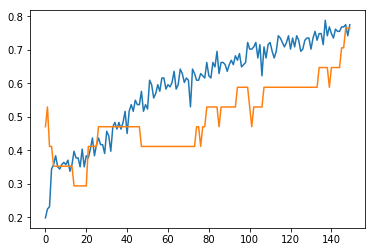

In [24]:
fig = plt.figure(figsize=(6, 4))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.show()

In [26]:
model.save('model_new_210.h5')

In [27]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 4, 25)      0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 1, 2, 25)      0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 1, 9, 25)      0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 1, 5, 25)      0                                            
___________________________________________________________________________________________

In [29]:
intermediate_layer_model = Model(input=model.input,
                                 output=model.get_layer('dense_1').output)

In [30]:
from utils import stack_test_data

In [31]:
print(spike_data_binned.shape)

(168, 46, 400)


In [37]:
spike_stack = stack_test_data(spike_data_binned, 25, 20)
lfp_stack = stack_test_data(lfp_data_sampled, 25, 20)

In [39]:
all_lower = np.zeros((168, 18, 10))
for i in range(18):
    test_data = organize_tetrode(spike_stack[:, i, :, :], lfp_stack[:, i, :, :], 
                                 tetrode_ids, tetrode_units, verbose=False)
    lower = intermediate_layer_model.predict(test_data)
    all_lower[:, i, :] = lower

In [40]:
np.save('latent_layer_new_210.npy', all_lower)